In [11]:
# upload zip
up=files.upload()
zip_name=list(up.keys())[0]

# unzip
with zipfile.ZipFile(zip_name, 'r') as zf:
    zf.extractall("data")

Saving archive.zip to archive (3).zip


/tmp/ipython-input-1197869978.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data.csv", encoding="latin1")


samples: 419509
a: 1.0
b: 0.6
0 1.3984493017196655 0.6481242775917053
500 1.4774806499481201 0.685863733291626
1000 1.4608607292175293 0.7434817552566528
1500 1.3744360208511353 0.7632248401641846
2000 1.3805525302886963 0.7758921980857849
2500 1.3774943351745605 0.7754684686660767
3000 1.4006942510604858 0.7361992001533508
3500 1.469071388244629 0.7262529730796814
4000 1.3085124492645264 0.854926347732544
4500 1.3013293743133545 0.83808434009552
5000 1.4625306129455566 0.6854325532913208
5500 1.3569419384002686 0.8914816975593567


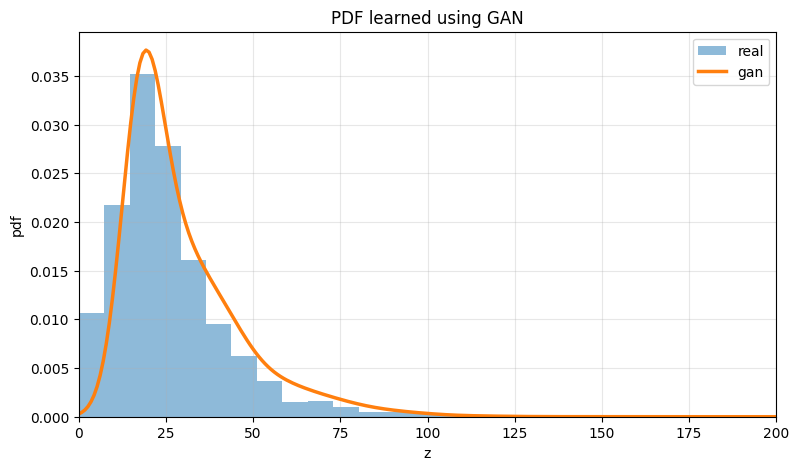

done


In [2]:
# import
import zipfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from google.colab import files

# seed
torch.manual_seed(0)
np.random.seed(0)

# read csv
df = pd.read_csv("data/data.csv", encoding="latin1")

# take no2
x = df["no2"].dropna().values.reshape(-1,1)
print("samples:", len(x))

# roll
r = 102317161

# params
a = 0.5*(r%7)
b = 0.3*((r%5)+1)

print("a:", a)
print("b:", b)

# transform
z = x + a*np.sin(b*x)

# scale
sc = StandardScaler()
z_s = sc.fit_transform(z)
z_t = torch.tensor(z_s, dtype=torch.float32)

# generator
class Gnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = nn.Sequential(
            nn.Linear(1,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.m(x)

# discriminator
class Dnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = nn.Sequential(
            nn.Linear(1,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.m(x)

G = Gnet()
D = Dnet()

# loss
loss = nn.BCELoss()

# slow learning rate
opt_g = optim.Adam(G.parameters(), lr=0.00025)
opt_d = optim.Adam(D.parameters(), lr=0.00015)


# train settings
ep = 6000
bs = 256

for i in range(ep):

    idx = np.random.randint(0, z_t.size(0), bs)
    real = z_t[idx]

    real_y = torch.ones(bs,1)*0.9
    fake_y = torch.zeros(bs,1)

    # train D
    noise = torch.randn(bs,1)
    fake = G(noise)

    d_loss = loss(D(real), real_y) + loss(D(fake.detach()), fake_y)
    opt_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    # train G twice
    for _ in range(1):
        noise = torch.randn(bs,1)
        fake = G(noise)
        g_loss = loss(D(fake), real_y)

        opt_g.zero_grad()
        g_loss.backward()
        opt_g.step()

    if i%500==0:
        print(i, d_loss.item(), g_loss.item())

# generate
with torch.no_grad():
    z_fake = G(torch.randn(40000,1)).numpy()

# inverse scale
z_fake = sc.inverse_transform(z_fake)
z_real = sc.inverse_transform(z_t.numpy())

# kde
k = gaussian_kde(z_fake.flatten(), bw_method=0.35)

vals = np.linspace(
    min(z_real.min(), z_fake.min()),
    max(z_real.max(), z_fake.max()),
    1000
)

vals = vals[vals<200]

# plot
plt.figure(figsize=(9,5))
plt.hist(z_real.flatten(), bins=120, density=True, alpha=0.5, label="real")
plt.plot(vals, k(vals), linewidth=2.5, label="gan")

plt.xlabel("z")
plt.ylabel("pdf")
plt.title("PDF learned using GAN")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0,200)
plt.show()

print("done")